Автор: Лейман М.А.   
Дата создания: 22.03.2025  

# Задание ZALA  
## 4. Детектирование множества объектов
### ___Модель___: __YOLO11s__ 

#### Многоклассовая детекция

## Импорты

In [1]:
%matplotlib inline

In [2]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import torch
from matplotlib import rcParams
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = (14,6)


print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/develops/python/env1/bin/python

Текущее положение: 
/home/maksim/develops/python/Zala_task/Zala_task


## Проверка GPU

In [3]:
# устанавливаем device если gpu или cpu

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.7.1+cu126
версия  cuDNN:           91100
Tue Aug 12 19:57:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   57C    P5             24W /  170W |     592MiB /  12288MiB |     26%      Default |
|                                         

In [4]:
# Получаем текущую директорию
path_dir = os.getcwd()
print("Текущая директория:", path_dir)

DATA_DIR = os.path.abspath(os.path.join(path_dir, 'dataset'))
print("Путь к dataset:", DATA_DIR)


Текущая директория: /home/maksim/develops/python/Zala_task/Zala_task
Путь к dataset: /home/maksim/develops/python/Zala_task/Zala_task/dataset


## Обучение

### Yolo

In [5]:
from glob import glob
import os
import numpy as np
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm_notebook
import torch.nn.functional as F
from torchvision import models

import time
from matplotlib import rcParams
import torch

# np.random.seed(42)
#set_global_seed(42)

In [8]:
from ultralytics import YOLO
import torch
from thop import profile

# model = YOLO("models/yolo11s.pt")
# model = YOLO("models/yolov8s.pt")  
model = YOLO("data/models/11s_best_UAVOD7.pt")


# Создаем фейковый вход с размером изображения
dummy_input = torch.randn(1, 3, 960, 960).to(model.device) 

# Профилируем модель
flops, params = profile(model.model, inputs=(dummy_input,))

# Выводим GFLOPs и количество параметров
print(f"GFLOPs: {flops / 1e9:.2f}")
print(f"Params: {params / 1e6:.2f}M")

model.info()

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
GFLOPs: 24.26
Params: 9.43M
YOLO11s summary: 181 layers, 9,430,888 parameters, 0 gradients, 21.6 GFLOPs


(181, 9430888, 0, 21.5635456)

In [7]:
# ['auto', 'Adam', 'SGD', 'AdamW', 'Adamax', 'NAdam', 'RAdam']

model.half();

torch.cuda.empty_cache()

for opt in ['AdamW']:
    for mosaic in [0.7]:
        for lr00 in [0.00001]:
            for iou0 in [0.5]:
                for batch in [12]:
                    # Очистка экрана перед каждой новой тренировкой
                    os.system('cls' if os.name == 'nt' else 'clear') 
                    clear_output(wait=True)  

                    print(f"Запуск тренировки: opt={opt}, batch={batch}, mosaic={mosaic}, lr0={lr00}, iou={iou0}")
                    
                    model.train(
                        data="data_1.yaml",
                        epochs=25,
                        imgsz=736,
                        batch=batch,
                        device="cuda",
                        lr0=lr00,
                        lrf=0.1,
                        cos_lr=True,
                        momentum=0.951,
                        weight_decay=0.01,
                        optimizer=opt,
                        cache=None,
                        max_det=290,            # максимальное количество детектируемых объектов        
                        single_cls=False,
                        patience=20,
                        verbose=True,
                        dropout=0.3,
                        freeze=0,
                        iou=iou0,  
                        half=True,          # 16-битная (FP16) арифметика
                        workers=0,
                        mosaic=mosaic,
                        close_mosaic=10,
                        multi_scale=False,  # разные размеры
                        mixup=0.15,         # Смешивание изображений в одно
                        copy_paste=0.2,     # Вставка объекта с другого изображения  
                        translate=0.05,     #  сдвиг xy
                        scale=0.1,  
                        exist_ok=True,       # Перезаписывать модель
                        warmup_epochs=3.0,    # количество эпох на разогрев  
                        fliplr=0.3,           # переворот по горизонтали
                        hsv_v=0.2,      #  Яркость
                        hsv_s=0.2,      # Насыщенность
                        hsv_h=0.02,     # Оттенок
                        bgr=0.05,       #  смена каналов
                        amp= True,         # Смешанная точность
                        fraction=1.0,      # используемая доля обучающих данных
                        val=True,
                        plots=True,
                  
                    )

                    time.sleep(1) 


Запуск тренировки: opt=AdamW, batch=12, mosaic=0.7, lr0=1e-05, iou=0.5
New https://pypi.org/project/ultralytics/8.3.148 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.95 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12029MiB)
engine/trainer: task=detect, mode=train, model=models/11s_best_UAVOD7.pt, data=data_1.yaml, epochs=25, time=None, patience=20, batch=12, imgsz=736, save=True, save_period=-1, cache=None, device=cuda, workers=0, project=None, name=train, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=290, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nm

train: Scanning /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_3/labels/train.cache... 16015 images, 52 backgrounds, 0 corrupt: 100%|██████████| 16015/16015 [00:00<?, ?it/s]
val: Scanning /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_3/labels/val.cache... 3071 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3071/3071 [00:00<?, ?it/s]

Plotting labels to runs/detect/train/labels.jpg... 


optimizer: AdamW(lr=1e-05, momentum=0.951) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.009375), 87 bias(decay=0.0)
Image sizes 736 train, 736 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      7.76G     0.8914     0.5291     0.9116        383        736: 100%|██████████| 1335/1335 [09:15<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:42<00:00,  3.01it/s]

                   all       3071      32350      0.784      0.712      0.767      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      9.96G      0.816     0.4793     0.8941        156        736: 100%|██████████| 1335/1335 [09:02<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.07it/s]

                   all       3071      32350      0.898      0.799      0.842      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      8.45G     0.7847     0.4598     0.8882        317        736: 100%|██████████| 1335/1335 [08:58<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.10it/s]

                   all       3071      32350      0.897      0.754      0.827      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      8.45G     0.7738     0.4525      0.885        251        736: 100%|██████████| 1335/1335 [08:54<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:40<00:00,  3.15it/s]

                   all       3071      32350      0.928      0.756      0.829       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      8.49G     0.7696     0.4509     0.8839        117        736: 100%|██████████| 1335/1335 [08:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.07it/s]

                   all       3071      32350      0.928      0.758      0.831      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      8.49G     0.7753     0.4546     0.8853        363        736: 100%|██████████| 1335/1335 [08:58<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.08it/s]

                   all       3071      32350       0.91      0.763      0.838      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      8.49G     0.7662     0.4493     0.8837        519        736: 100%|██████████| 1335/1335 [08:59<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.11it/s]

                   all       3071      32350      0.956      0.755      0.839      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      8.49G     0.7656     0.4473     0.8822        124        736: 100%|██████████| 1335/1335 [08:59<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.11it/s]

                   all       3071      32350      0.923      0.762       0.84      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      8.49G     0.7652     0.4484     0.8824        257        736: 100%|██████████| 1335/1335 [09:01<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:42<00:00,  3.02it/s]

                   all       3071      32350      0.945      0.758      0.844      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      8.49G       0.76     0.4461     0.8822        159        736: 100%|██████████| 1335/1335 [09:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.05it/s]

                   all       3071      32350      0.956       0.76      0.848      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      8.49G     0.7633      0.446     0.8816        246        736: 100%|██████████| 1335/1335 [08:58<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.12it/s]

                   all       3071      32350      0.928       0.76      0.847      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      8.49G     0.7647     0.4483     0.8827        433        736: 100%|██████████| 1335/1335 [09:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.11it/s]

                   all       3071      32350      0.945      0.752      0.845      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      8.49G     0.7591     0.4445     0.8809        110        736: 100%|██████████| 1335/1335 [08:57<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.08it/s]

                   all       3071      32350      0.925      0.763      0.848      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      8.49G     0.7596     0.4444     0.8817        327        736: 100%|██████████| 1335/1335 [09:01<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.09it/s]

                   all       3071      32350      0.927      0.764      0.849      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      8.49G     0.7597     0.4457     0.8821        395        736: 100%|██████████| 1335/1335 [09:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.10it/s]

                   all       3071      32350      0.938      0.765      0.851      0.614


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      8.49G     0.6332     0.3553     0.8368        348        736: 100%|██████████| 1335/1335 [08:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.10it/s]

                   all       3071      32350      0.938      0.768      0.852      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      8.49G      0.629     0.3532     0.8359        507        736: 100%|██████████| 1335/1335 [08:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.06it/s]

                   all       3071      32350       0.93      0.772      0.853      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      8.49G     0.6265     0.3512     0.8354        364        736: 100%|██████████| 1335/1335 [08:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.08it/s]

                   all       3071      32350      0.921      0.775      0.854       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      8.49G     0.6275     0.3512     0.8354        292        736: 100%|██████████| 1335/1335 [08:16<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.08it/s]

                   all       3071      32350      0.934      0.771      0.857      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      8.49G     0.6253     0.3507     0.8351        365        736: 100%|██████████| 1335/1335 [08:13<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.08it/s]

                   all       3071      32350      0.922      0.776      0.858      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      8.49G     0.6242     0.3502     0.8348        200        736: 100%|██████████| 1335/1335 [08:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.06it/s]

                   all       3071      32350      0.927      0.771      0.857      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      8.49G     0.6241     0.3498     0.8344        134        736: 100%|██████████| 1335/1335 [08:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.08it/s]

                   all       3071      32350       0.84      0.818      0.861      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      8.49G     0.6249     0.3497     0.8351        102        736: 100%|██████████| 1335/1335 [08:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.08it/s]

                   all       3071      32350      0.849      0.831      0.864      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      8.49G     0.6248     0.3502     0.8349        127        736: 100%|██████████| 1335/1335 [08:10<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.07it/s]

                   all       3071      32350      0.847      0.827      0.867      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      8.49G      0.624     0.3495     0.8346         87        736: 100%|██████████| 1335/1335 [08:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:42<00:00,  3.05it/s]

                   all       3071      32350      0.845      0.823      0.865      0.627



25 epochs completed in 3.910 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.95 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12029MiB)
YOLO11s summary (fused): 100 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:41<00:00,  3.09it/s]


                   all       3071      32350      0.852      0.837      0.868      0.627
              building       2309      23389      0.948      0.952      0.978      0.778
                 plane         10         16      0.749      0.875      0.931      0.742
              fish net        300       1255      0.973      0.964      0.991      0.889
                harbor         31         37      0.518      0.378       0.35      0.187
                  well       1187       2836      0.945      0.959      0.984      0.695
               vehicle       1563       3329      0.893      0.858      0.917      0.508
                  ship        595       1488       0.94      0.869      0.924      0.592
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train


## Первая итерация обучения 
### На начальном датасете  __UAVOD__  844 изображения.

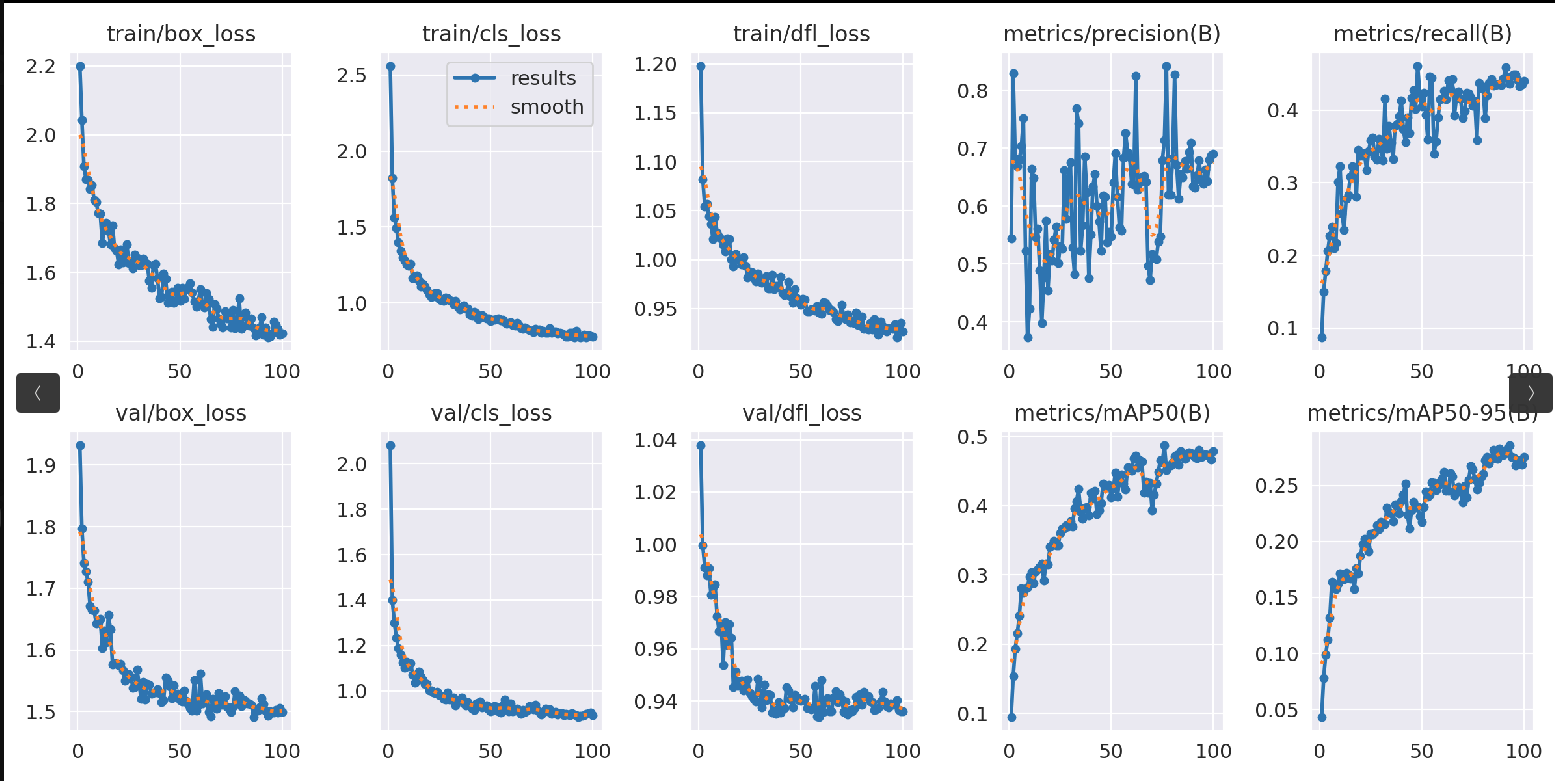

### На увеличенном датасете  __UAVOD__  12000 изображений.  
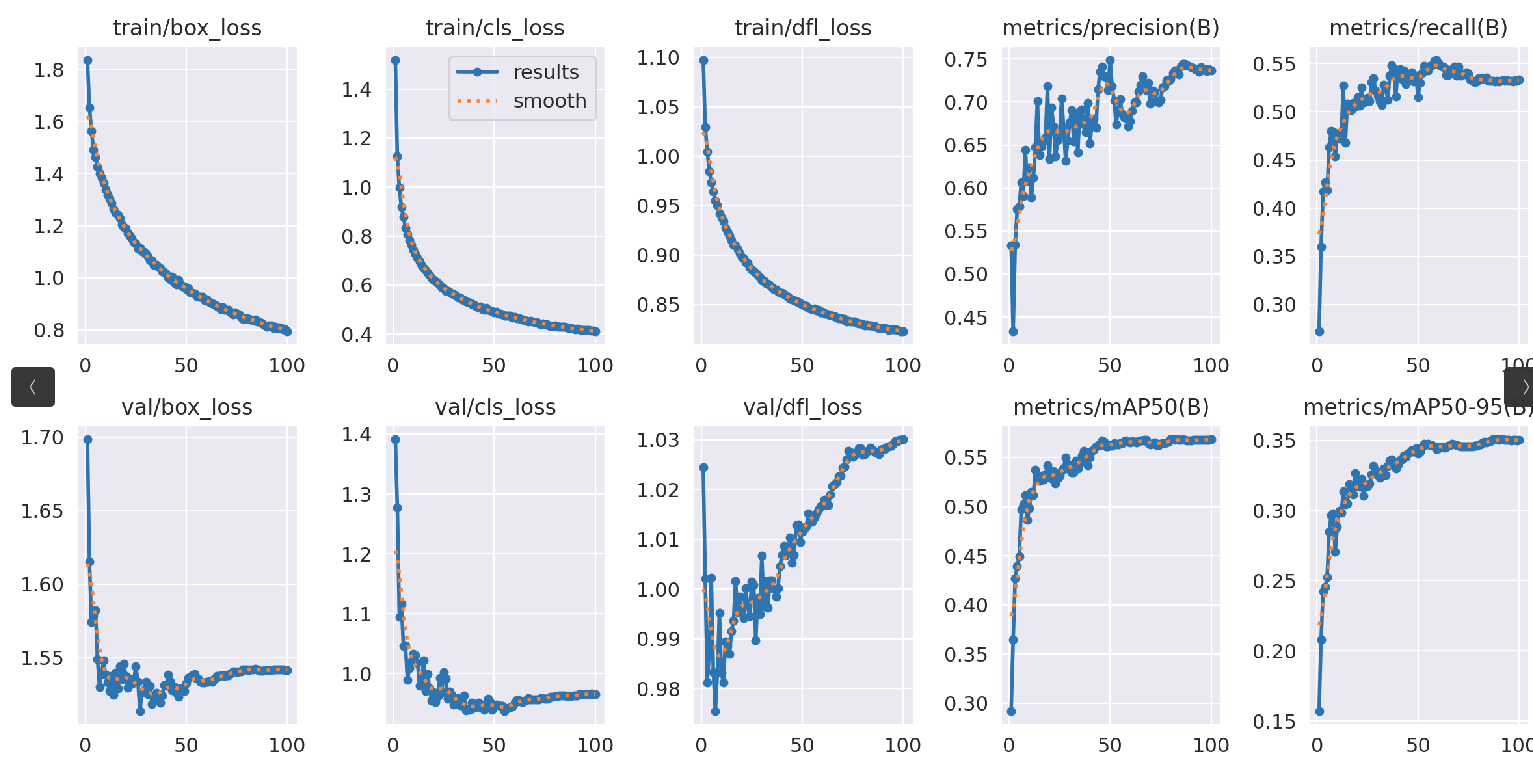


###  Итоговое обучение  
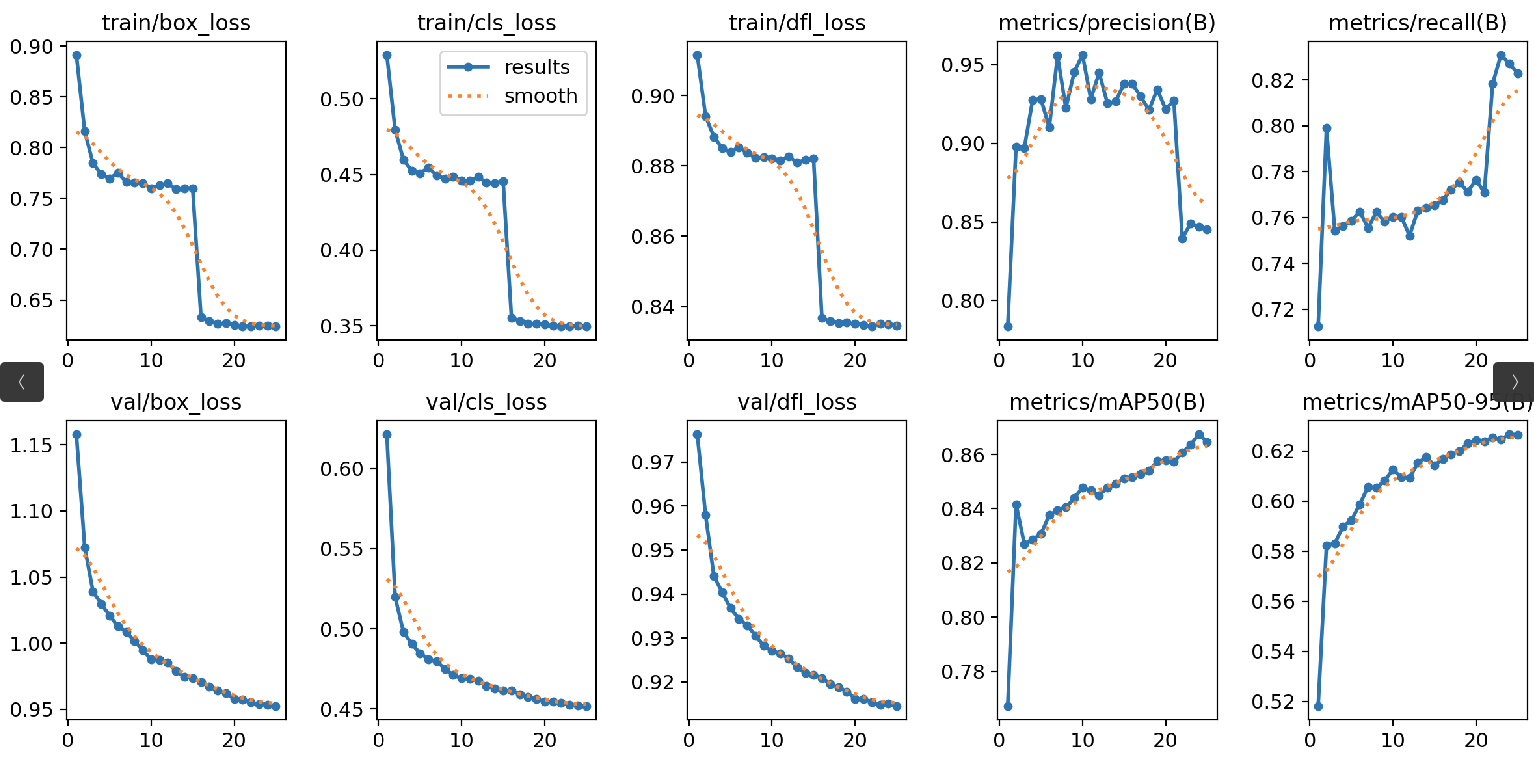  

In [9]:
model = YOLO("data/models/11s_best_UAVOD7.pt")

In [ ]:
from utils.inference import metrics_model

metrics_model(model, split="test", iou=0.5)

Ultralytics 8.3.166 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 11901MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 674.0±189.6 MB/s, size: 330.8 KB)


val: Scanning /home/maksim/develops/python/Zala_task/Zala_task/data/dataset/dataset_full_1/labels/test... 2577 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2577/2577 [00:00<00:00, 4045.42it/s]

val: New cache created: /home/maksim/develops/python/Zala_task/Zala_task/data/dataset/dataset_full_1/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 162/162 [00:26<00:00,  6.15it/s]


                   all       2577      24100      0.935       0.88      0.928      0.638
              building       1804      16808       0.96      0.926      0.974      0.765
                 plane         22        171      0.934      0.965      0.977      0.703
              fish net        170        636      0.966      0.959      0.988      0.882
                harbor         36        132       0.83      0.773      0.771      0.365
                  well        873       1907      0.963      0.932      0.972      0.677
               vehicle       1510       3471      0.936      0.823      0.908      0.524
                  ship        418        975      0.957      0.783      0.905      0.552
Speed: 0.3ms preprocess, 7.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val2

=== Итоговые метрики по тестовому набору ===
Средняя точность (Precision): 0.935
Средняя полнота (Recall): 0.880
Средняя AP50 (IoU=0.50): 0.928
Средний mAP50-95: 0.638


In [19]:
metrics_model(model, split="test", iou=0.7)

Ultralytics 8.3.95 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12029MiB)


val: Scanning /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_3/labels/test.cache... 2789 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2789/2789 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:29<00:00,  5.90it/s]


                   all       2789      31916       0.83      0.824      0.851      0.623
              building       2263      23693      0.952      0.955      0.979       0.79
                 plane          5          8      0.725      0.875      0.928      0.733
              fish net        331       1310      0.966      0.974      0.992      0.899
                harbor         32         35      0.384       0.25      0.229        0.1
                  well       1236       2930      0.951      0.966      0.989      0.721
               vehicle       1115       2320      0.883      0.851      0.901      0.496
                  ship        619       1620      0.949      0.894      0.941      0.619
Speed: 0.2ms preprocess, 7.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val6

=== Итоговые метрики по тестовому набору ===
Средняя точность (Precision): 0.830
Средняя полнота (Recall): 0.824
Средняя AP50 (IoU=0.70): 0.851
Средний mAP50-95: 0.623


### Итоги обучения. Метрики на тестовом наборе.



====== Итоговые метрики по тестовому набору UAVOD __начальный dataset__ ===    100 Эпох.  модель 0  
Средняя точность (Precision): 0.537  
Средняя полнота (Recall): 0.356  
Средняя AP50 (IoU=0.50): 0.391  
Средний mAP50-95: 0.203  


====== Итоговые метрики по тестовому набору UAVOD __full_dataset__ ===    100 Эпох.   модель 1  
Средняя точность (Precision): 0.673  
Средняя полнота (Recall): 0.507  
Средняя AP50 (IoU=0.50): 0.530  
Средний mAP50-95: 0.300  

### Продолжение обучения  


====== Итоговые метрики по тестовому набору UAVOD __full_dataset__ ===   модель 2  

 5 Эпох.   После применения __mixup__  и  __copy_paste__  

Средняя точность (Precision): 0.691  
Средняя полнота (Recall): 0.596  
Средняя AP50 (IoU=0.50): 0.627  
Средний mAP50-95: 0.365  


====== Итоговые метрики по тестовому набору UAVOD __full_dataset__ ===    

5 Эпох.   После применения __mixup__  и  __copy_paste__  размер изображений (640)  

Средняя точность (Precision): 0.775  
Средняя полнота (Recall): 0.614  
Средняя AP50 (IoU=0.50): 0.673  
Средний mAP50-95: 0.401  


====== Итоговые метрики по тестовому набору UAVOD __full_dataset__ ===     модель  3  

15 Эпох.   После применения __mixup__  и  __copy_paste__  размер изображений (640)  фиксированный     

Средняя точность (Precision): 0.818  
Средняя полнота (Recall): 0.624  
Средняя AP50 (IoU=0.50): 0.691  
Средний mAP50-95: 0.435  



====== Итоговые метрики по тестовому набору  ===  4 модель   

размер изображений (736)  фиксированный  + добавлены изображения с датасета __DOTA__   

Средняя точность (Precision): 0.907  
Средняя полнота (Recall): 0.734  
Средняя AP50 (IoU=0.50): 0.812  
Средний mAP50-95: 0.564  

=== Итоговые метрики по тестовому набору ===  6 модель 

размер изображений (736)  фиксированный  + добавлены изображения с датасета __DOTA__  и  __VEDAI__   
удалены малочисленные классы  

Средняя точность (Precision): 0.919  
Средняя полнота (Recall): 0.844  
Средняя AP50 (IoU=0.50): 0.891  
Средний mAP50-95: 0.642  




## Сравнение 

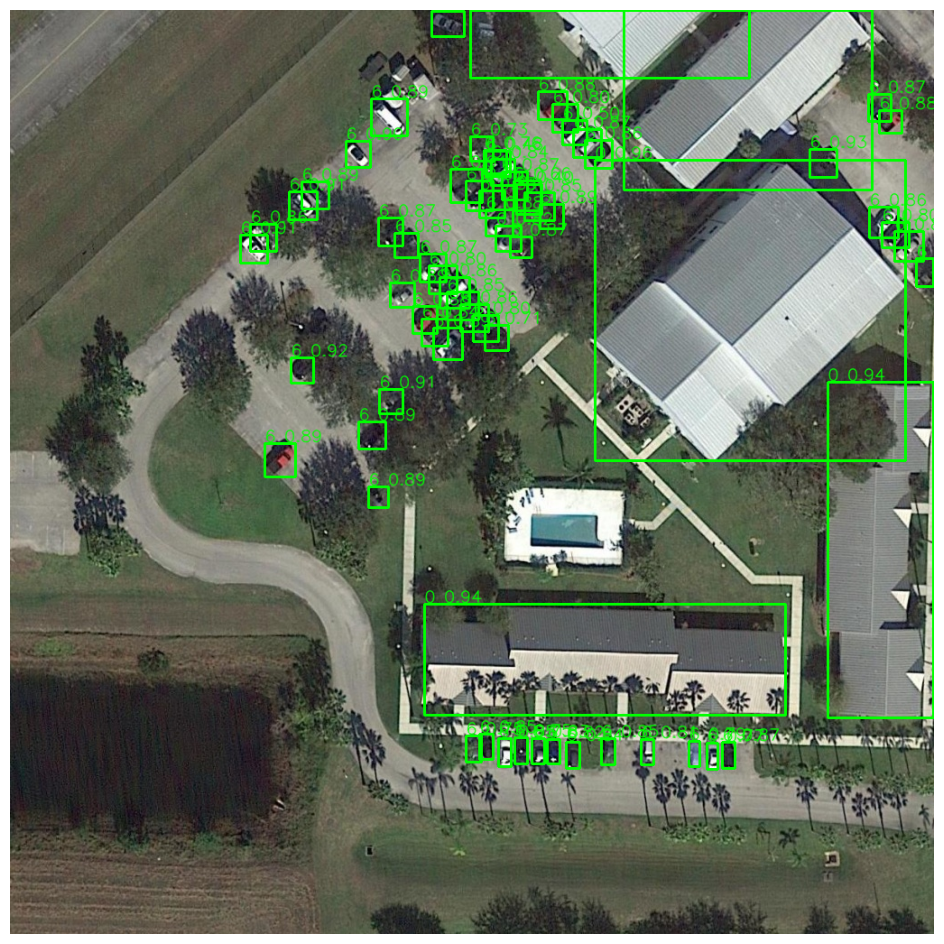

In [ ]:
from utils.inference import inference_model, inference_model_yolo

image_size = 736

# Путь к изображению
current_directory = os.getcwd()  
patch_image = os.path.join(current_directory, "data/dataset/TEST/images/P0179_0_crop8.jpg")


inference_model(model, patch_image)

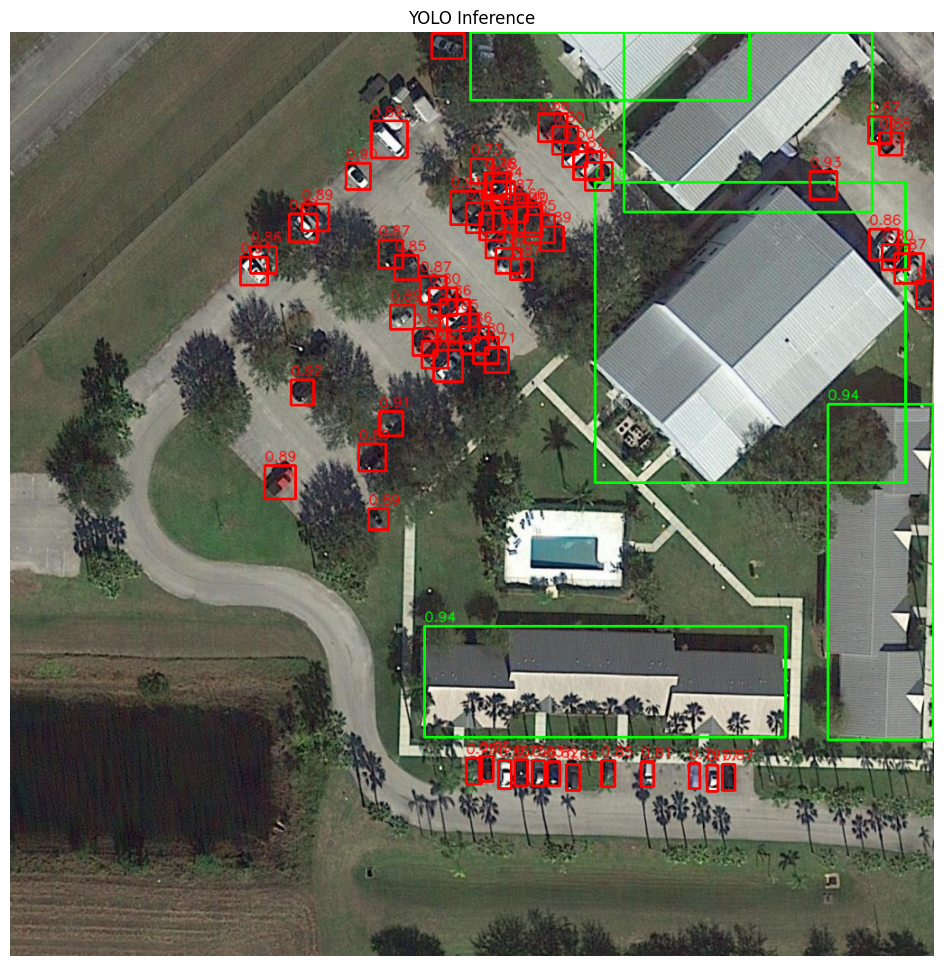

In [18]:
inference_model_yolo(model, patch_image)

# Инфо модели

In [1]:
import torch
from ultralytics import YOLO
from thop import profile
# model = YOLO("models/yolo11s.pt")
# model = YOLO("models/yolov8s.pt")  
model = YOLO("models/11s_best_UAVOD4.pt")

model.info()

YOLO11s summary: 181 layers, 9,431,662 parameters, 0 gradients, 21.6 GFLOPs


(181, 9431662, 0, 21.567846399999997)

In [ ]:
import torch
from ultralytics import YOLO
from thop import profile

# Загружаем YOLO-модель 
model = YOLO("data/models/11s_best_UAVOD5.pt").model

# Создаем входные тензоры разного размера
dummy_736 = torch.randn(1, 3, 736, 736)
dummy_1024 = torch.randn(1, 3, 1024, 1024)

# Вычисляем FLOPs и параметры для 
flops_736, params_736= profile(model, inputs=(dummy_736,), verbose=False)

# Вычисляем FLOPs и параметры для 1024x1024
flops_1024, params_1024 = profile(model, inputs=(dummy_1024,), verbose=False)

# Возвращаем данные в GFLOPs и миллионах параметров
{
    "736x736": {
        "GFLOPs": flops_736 / 1e9,
        "Params (M)": params_736 / 1e6
    },
    "1024x1024": {
        "GFLOPs": flops_1024 / 1e9,
        "Params (M)": params_1024 / 1e6
    }
}


{'736x736': {'GFLOPs': 14.266004288, 'Params (M)': 9.432823},
 '1024x1024': {'GFLOPs': 27.615100928, 'Params (M)': 9.432823}}

In [2]:
from ptflops import get_model_complexity_info



with torch.cuda.device(0):  
    macs, params = get_model_complexity_info(model, (3, 736, 736), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f'FLOPs: {macs}')
    print(f'Parameters: {params}')

FLOPs: 14.23 GMac
Parameters: 0


# Подготовка к развёртыванию

In [ ]:
#!yolo export model=/home/maksim/develops/python/devsTraining/zala_task/models/11s_best_UAVOD5.pt format=onnx


Ultralytics 8.3.95 🚀 Python-3.12.9 torch-2.6.0+cu124 CPU (11th Gen Intel Core(TM) i5-11400F 2.60GHz)
YOLO11s summary (fused): 100 layers, 9,417,831 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from '/home/maksim/develops/python/devsTraining/zala_task/models/11s_best_UAVOD5.pt' with input shape (1, 3, 736, 736) BCHW and output shape(s) (1, 17, 11109) (18.3 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 1.0s, saved as '/home/maksim/develops/python/devsTraining/zala_task/models/11s_best_UAVOD5.onnx' (36.2 MB)

Export complete (1.5s)
Results saved to /home/maksim/develops/python/devsTraining/zala_task/models
Predict:         yolo predict task=detect model=/home/maksim/develops/python/devsTraining/zala_task/models/11s_best_UAVOD5.onnx imgsz=736  
Validate:        yolo val task=detect model=/home/maksim/develops/python/devsTraining/zala_task/models/11s_best_UAVOD5.onnx imgsz=736 data=data_1.yaml  
Visualize:   